In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
#from statsmodels.tsa.stattools import adfuller, kpss
#from statsmodels.tsa.stattools import acf, pacf
#from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, cross_validate
from sklearn.svm import LinearSVR, SVR
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings('ignore')

In [2]:
gold = pd.read_csv('ouro2.csv')
gold.columns = ['data', 'today_price']

# inverte dataframe para poder fazer as médias móveis com os valores corretos
gold = gold[::-1]

#Variação do preço do ouro
# gold['next_week_price'] = gold.today_price.shift(1)
# gold['last_week_price'] = gold.today_price.shift(-1)
# gold['delta'] = gold.today_price - gold.last_week_price
# #gold['s3'] = gold.delta.rolling(window=3).mean()
# #gold['s10'] = gold.delta.rolling(window=10).mean()
# gold['m3'] = gold.today_price.rolling(window=3).mean()
# gold['m5'] = gold.today_price.rolling(window=5).mean()
# gold['m7'] = gold.today_price.rolling(window=7).mean()
# gold['m9'] = gold.today_price.rolling(window=9).mean()
# # gold['m12'] = gold.today_price.rolling(window=12).mean()
# # gold['m14'] = gold.today_price.rolling(window=14).mean()
# # gold['m17'] = gold.today_price.rolling(window=17).mean()
# # gold['m21'] = gold.today_price.rolling(window=21).mean()
# # gold['m28'] = gold.today_price.rolling(window=28).mean()
# gold.dropna(inplace=True)
# print("Número de linhas: {}\nNúmero de colunas: {}".format(gold.shape[0], gold.shape[1]))
# gold.head()

gold['data']= pd.to_datetime(gold.data, dayfirst=True) #transform data into datetime

gold['last_week_price'] = gold.today_price.shift(1)
filtro = np.where(gold['today_price'] > gold['last_week_price'], 1, 0)
gold['target_subida'] = filtro
gold['next_week_price'] = gold.today_price.shift(-1)
gold['delta'] = gold.today_price - gold.last_week_price
gold['m3'] = gold.today_price.rolling(window=3).mean()
gold['m5'] = gold.today_price.rolling(window=5).mean()
gold['m7'] = gold.today_price.rolling(window=7).mean()
gold['m9'] = gold.today_price.rolling(window=9).mean()
gold.dropna(inplace=True)
gold.head(20)



,data,today_price,last_week_price,target_subida,next_week_price,delta,m3,m5,m7,m9
1087,2000-08-13,276.8,275.1,1,274.1,1.7,274.833333,276.46,278.085714,279.933333
1086,2000-08-20,274.1,276.8,0,277.0,-2.7,275.333333,275.26,276.785714,278.977778
1085,2000-08-27,277.0,274.1,1,273.3,2.9,275.966667,275.12,276.200000,277.522222
1084,2000-09-03,273.3,277.0,0,272.3,-3.7,274.800000,275.26,275.228571,276.422222
1083,2000-09-10,272.3,273.3,0,271.8,-1.0,274.200000,274.70,274.457143,275.444444
1082,2000-09-17,271.8,272.3,0,273.6,-0.5,272.466667,273.70,274.342857,274.522222
1081,2000-09-24,273.6,271.8,1,269.3,1.8,272.566667,273.60,274.128571,274.066667
1080,2000-10-01,269.3,273.6,0,272.4,-4.3,271.566667,272.06,273.057143,273.700000
1079,2000-10-08,272.4,269.3,1,271.2,3.1,271.766667,271.88,272.814286,273.400000
1078,2000-10-15,271.2,272.4,0,264.4,-1.2,270.966667,271.66,271.985714,272.777778


In [3]:
gold.tail()

,data,today_price,last_week_price,target_subida,next_week_price,delta,m3,m5,m7,m9
5,2021-05-09,1840.0,1833.5,1,1878.9,6.5,1814.433333,1801.08,1783.214286,1773.866667
4,2021-05-16,1878.9,1840.0,1,1905.3,38.9,1850.800000,1820.42,1804.442857,1788.655556
3,2021-05-23,1905.3,1878.9,1,1892.0,26.4,1874.733333,1845.50,1827.085714,1807.411111
2,2021-05-30,1892.0,1905.3,0,1879.6,-13.3,1892.066667,1869.94,1842.771429,1825.377778
1,2021-06-06,1879.6,1892.0,0,1868.0,-12.4,1892.300000,1879.16,1857.014286,1840.133333


### Normal series

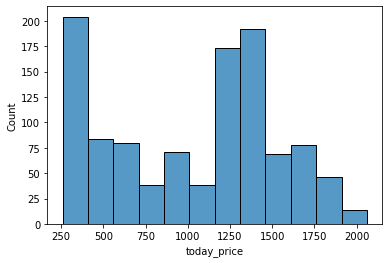

In [4]:
sns.histplot(gold.today_price)

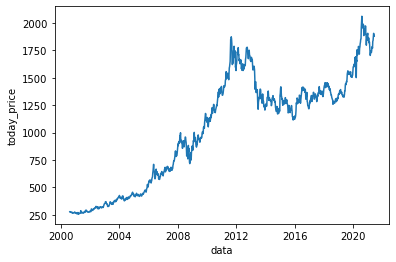

In [5]:
#print timeline graph
sns.lineplot(x=gold.data, y=gold.today_price)
#sns.lineplot(x=gold.data,y=gold.m7)
#sns.lineplot(x=gold.data,y=gold.m14)
#sns.lineplot(x=gold.data,y=gold.m21)

## Conjunto de treinamento

In [6]:
# Consideramos como teste as 100 semanas mais recentes

y_test = gold.next_week_price.tail(100) 
X_test = gold.tail(100).drop(['data','today_price','next_week_price'],axis=1)

print('Conjunto y de teste')
print("Número de linhas: {}".format(y_test.shape[0]))
y_test.head()

Conjunto y de teste
Número de linhas: 100


100    1460.4
99     1485.3
98     1534.5
97     1549.2
96     1563.5
Name: next_week_price, dtype: float64

In [7]:
X_train = gold.head(-100).drop(['data','today_price','next_week_price'],axis=1)
y_train = gold.next_week_price.head(-100)
print('Conjunto y de treino')
print("Número de linhas: {}".format(y_train.shape[0]))
y_train.head()

Conjunto y de treino
Número de linhas: 987


1087    274.1
1086    277.0
1085    273.3
1084    272.3
1083    271.8
Name: next_week_price, dtype: float64

## Baseline

In [8]:
baseline = X_test.query('delta > 0')
acertos_bl = baseline.shape[0]
print("Acertos: {}".format(acertos_bl))

Acertos: 59


# Com delta

### Definindo os conjuntos de entrada para treino e teste

In [9]:
X_test = gold.filter(['delta','m3','m5','m7'],axis=1).tail(100)
print('Conjunto X de teste')
print("Número de linhas: {}\nNúmero de colunas: {}".format(X_test.shape[0], X_test.shape[1]))
X_test.head()

Conjunto X de teste
Número de linhas: 100
Número de colunas: 4


,delta,m3,m5,m7
100,14.6,1451.000000,1446.50,1427.985714
99,-5.1,1458.933333,1452.04,1439.200000
98,24.9,1470.400000,1459.74,1454.028571
97,49.2,1493.400000,1479.32,1468.571429
96,14.7,1523.000000,1498.98,1483.200000


In [10]:
X_train = gold.filter(['delta','m3','m5','m7'],axis=1).head(-100)
print('Conjunto X de treino')
print("Número de linhas: {}\nNúmero de colunas: {}".format(X_train.shape[0], X_train.shape[1]))
X_train.head()

Conjunto X de treino
Número de linhas: 987
Número de colunas: 4


,delta,m3,m5,m7
1087,1.7,274.833333,276.46,278.085714
1086,-2.7,275.333333,275.26,276.785714
1085,2.9,275.966667,275.12,276.200000
1084,-3.7,274.800000,275.26,275.228571
1083,-1.0,274.200000,274.70,274.457143


## Linear Regressor

In [11]:
linear = LinearRegression().fit(X_train, y_train)
print("Linear Regression model")
print("Gold Week Price (y) = %.2f * Delta (x1) \
+ %.2f * 3 Days Moving Average (x2) \
+ %.2f * 5 Days Moving Average (x3) \
+ %.2f * 7 Days Moving Average (x4) \
+ %.2f (constant)" % (linear.coef_[0], linear.coef_[1], linear.coef_[2], linear.coef_[3], linear.intercept_))

Linear Regression model
Gold Week Price (y) = 0.64 * Delta (x1) + 1.42 * 3 Days Moving Average (x2) + -0.71 * 5 Days Moving Average (x3) + 0.29 * 7 Days Moving Average (x4) + 3.39 (constant)


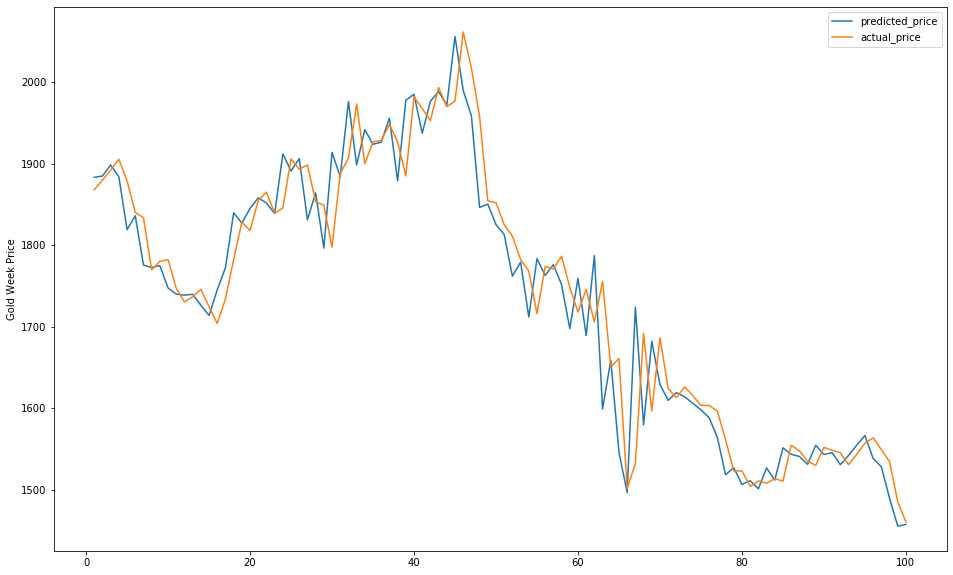

RMSE: 2304.5158832474285


In [12]:
predicted_price = linear.predict(X_test)
d = {'actual_price': y_test,'predicted_price': predicted_price}
df = pd.DataFrame(data=d)
df['actual_var'] = df.actual_price.shift(1) - df.actual_price
df['actual_var_sign'] = np.sign(df.actual_var)
df['predicted_var'] = df.predicted_price.shift(1) - df.predicted_price
df['predicted_var_sign'] = df.predicted_var/abs(df.predicted_var)
df['correct_prediction'] = np.equal(df.actual_var_sign, df.predicted_var_sign)
predicted_price = pd.DataFrame(
    predicted_price, index=y_test.index, columns=['price'])
predicted_price.plot(figsize=(16, 10))
y_test.plot()
plt.legend(['predicted_price', 'actual_price'])
plt.ylabel("Gold Week Price")
plt.show()
rmse = mean_squared_error(y_test, predicted_price)
print("RMSE:", rmse)

In [13]:
df

,actual_price,predicted_price,actual_var,actual_var_sign,predicted_var,predicted_var_sign,correct_prediction
100,1460.4,1457.395671,NaN,NaN,NaN,NaN,False
99,1485.3,1455.348648,-24.9,-1.0,2.047023,1.0,False
98,1534.5,1489.620933,-49.2,-1.0,-34.272285,-1.0,True
97,1549.2,1528.116955,-14.7,-1.0,-38.496023,-1.0,True
96,1563.5,1538.333367,-14.3,-1.0,-10.216411,-1.0,True
...,...,...,...,...,...,...,...
5,1878.9,1818.836518,-38.9,-1.0,17.120495,1.0,False
4,1905.3,1883.582359,-26.4,-1.0,-64.745841,-1.0,True
3,1892.0,1898.287019,13.3,1.0,-14.704660,-1.0,False
2,1879.6,1884.675495,12.4,1.0,13.611524,1.0,True


In [14]:
df.head(30)
print("Número de linhas: {}".format(df.shape[0]))

Número de linhas: 100


In [15]:
r2_score = linear.score(X_test, y_test)*100
float("{0:.2f}".format(r2_score))

90.73

In [16]:
res = df.query('correct_prediction == True')
acertos = res.shape[0]
print("Acertos: {}".format(acertos))

Acertos: 49


## Ridge

In [17]:
alpha_list = 10**(np.random.uniform(-3, 3, 50))
final_r2 = np.NINF
for alpha_value in alpha_list:
    ridge = Ridge(alpha=alpha_value).fit(X_train, y_train)
    predicted_price = ridge.predict(X_test)
    r2_score = ridge.score(X_test, y_test)
    if r2_score > final_r2:
        final_r2 = r2_score
        final_alpha = alpha_value
        final_coef0 = ridge.coef_[0]
        final_coef1 = ridge.coef_[1]
        final_coef2 = ridge.coef_[2]
        final_coef3 = ridge.coef_[3]
        final_intercept = ridge.intercept_
print("Resultado da busca por hiperparâmetros:")
print("Melhor R2 = {}".format(final_r2))
print("Melhor alpha = {}".format(final_alpha))
print("Linear Regression model with Ridge (l2) regularization")
print("Gold Week Price (y) = %.2f * Delta (x1) \
+ %.2f * 3 Days Moving Average (x2) \
+ %.2f * 5 Days Moving Average (x3) \
+ %.2f * 7 Days Moving Average (x4) \
+ %.2f (constant)" % (final_coef0, final_coef1, final_coef2, final_coef3, final_intercept))

Resultado da busca por hiperparâmetros:
Melhor R2 = 0.9074801969243006
Melhor alpha = 836.2961182436792
Linear Regression model with Ridge (l2) regularization
Gold Week Price (y) = 0.64 * Delta (x1) + 1.40 * 3 Days Moving Average (x2) + -0.67 * 5 Days Moving Average (x3) + 0.27 * 7 Days Moving Average (x4) + 3.40 (constant)


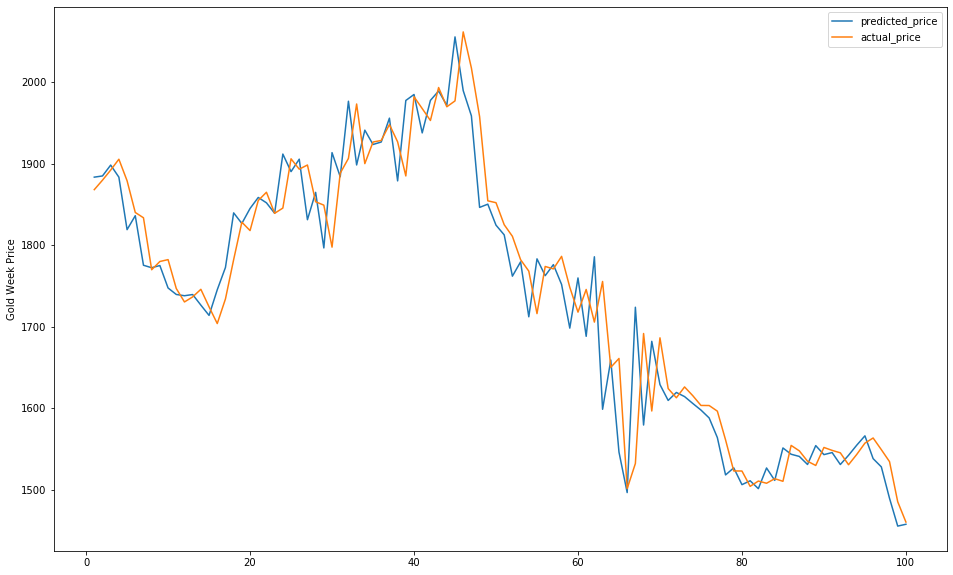

RMSE: 2299.877058912486


In [18]:
ridge = Ridge(alpha=final_alpha).fit(X_train, y_train)
predicted_price = ridge.predict(X_test)
d = {'actual_price': y_test,'predicted_price': predicted_price}
df = pd.DataFrame(data=d)
df['actual_var'] = df.actual_price.shift(-1) - df.actual_price
df['actual_var_sign'] = np.sign(df.actual_var)
df['predicted_var'] = df.predicted_price.shift(1) - df.predicted_price
df['predicted_var_sign'] = df.predicted_var/abs(df.predicted_var)
df['correct_prediction'] = np.equal(df.actual_var_sign, df.predicted_var_sign)
predicted_price = pd.DataFrame(
    predicted_price, index=y_test.index, columns=['price'])
predicted_price.plot(figsize=(16, 10))
y_test.plot()
plt.legend(['predicted_price', 'actual_price'])
plt.ylabel("Gold Week Price")
plt.show()
rmse = mean_squared_error(y_test, predicted_price)
print("RMSE:", rmse)

In [19]:
df.head(30)
print("Número de linhas: {}".format(df.shape[0]))

Número de linhas: 100


In [20]:
r2_score = ridge.score(X_test, y_test)*100
float("{0:.2f}".format(r2_score))

90.75

In [21]:
res = df.query('correct_prediction == True')
acertos = res.shape[0]
print("Acertos: {}".format(acertos))

Acertos: 49


## Lasso

In [22]:
alpha_list = 10**(np.random.uniform(-3, 3, 50))
final_r2 = np.NINF
for alpha_value in alpha_list:
    lasso = Lasso(alpha=alpha_value, max_iter=10000).fit(X_train, y_train)
    predicted_price = lasso.predict(X_test)
    r2_score = lasso.score(X_test, y_test)
    if r2_score > final_r2:
        final_r2 = r2_score
        final_alpha = alpha_value
        final_coef0 = lasso.coef_[0]
        final_coef1 = lasso.coef_[1]
        final_coef2 = lasso.coef_[2]
        final_coef3 = lasso.coef_[3]
        final_intercept = lasso.intercept_
print("Resultado da busca por hiperparâmetros:")
print("Melhor R2 = {}".format(final_r2))
print("Melhor alpha = {}".format(final_alpha))
print("Lasso (l1) regularization")
print("Gold Week Price (y) = %.2f * Delta (x1) \
+ %.2f * 3 Days Moving Average (x2) \
+ %.2f * 5 Days Moving Average (x3) \
+ %.2f * 7 Days Moving Average (x4) \
+ %.2f (constant)" % (final_coef0, final_coef1, final_coef2, final_coef3, final_intercept))

Resultado da busca por hiperparâmetros:
Melhor R2 = 0.915183240857872
Melhor alpha = 163.83247039869448
Lasso (l1) regularization
Gold Week Price (y) = 0.42 * Delta (x1) + 1.00 * 3 Days Moving Average (x2) + 0.00 * 5 Days Moving Average (x3) + 0.00 * 7 Days Moving Average (x4) + 4.76 (constant)


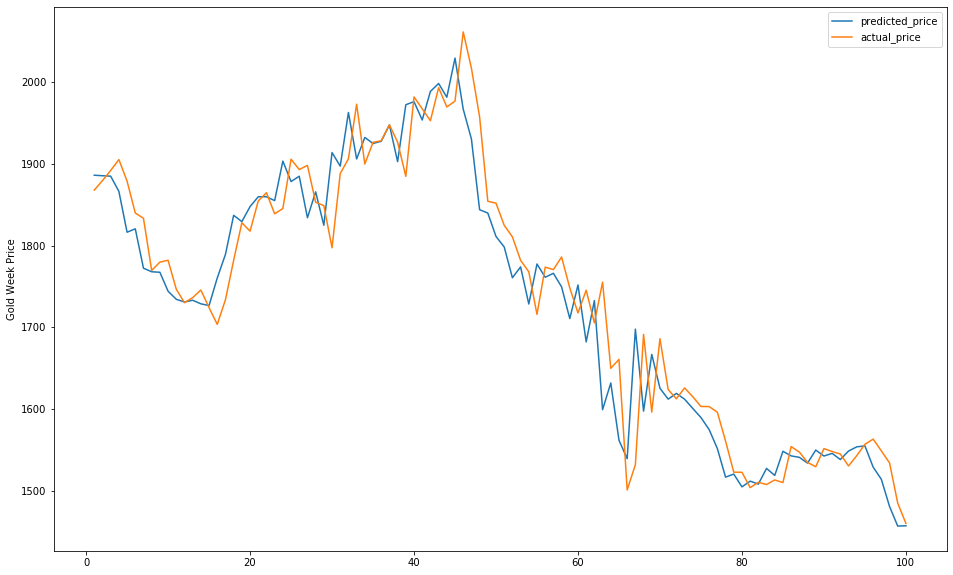

RMSE: 2108.3931447917385


In [23]:
lasso = Lasso(alpha=final_alpha, max_iter=10000).fit(X_train, y_train)
predicted_price = lasso.predict(X_test)
d = {'actual_price': y_test,'predicted_price': predicted_price}
df = pd.DataFrame(data=d)
df['actual_var'] = df.actual_price.shift(-1) - df.actual_price
df['actual_var_sign'] = np.sign(df.actual_var)
df['predicted_var'] = df.predicted_price.shift(1) - df.predicted_price
df['predicted_var_sign'] = df.predicted_var/abs(df.predicted_var)
df['correct_prediction'] = np.equal(df.actual_var_sign, df.predicted_var_sign)
predicted_price = pd.DataFrame(
    predicted_price, index=y_test.index, columns=['price'])
predicted_price.plot(figsize=(16, 10))
y_test.plot()
plt.legend(['predicted_price', 'actual_price'])
plt.ylabel("Gold Week Price")
plt.show()
rmse = mean_squared_error(y_test, predicted_price)
print("RMSE:", rmse)

In [24]:
df.head(30)
print("Número de linhas: {}".format(df.shape[0]))

Número de linhas: 100


In [25]:
r2_score = lasso.score(X_test, y_test)*100
float("{0:.2f}".format(r2_score))

91.52

In [26]:
res = df.query('correct_prediction == True')
acertos = res.shape[0]
print("Acertos: {}".format(acertos))

Acertos: 47


## Random Forest Regressor

In [27]:
n_estimators_list = [25, 50, 75]
final_r2 = np.NINF
for n_estimators_value in n_estimators_list:
    rf = RandomForestRegressor(n_estimators=n_estimators_value, max_features=2).fit(X_train, y_train)
    predicted_price = rf.predict(X_test)
    r2_score = rf.score(X_test, y_test)
    if r2_score > final_r2:
        final_r2 = r2_score
        final_n_estimators = n_estimators_value    
print("Melhor R2 = {}".format(final_r2))
print("Valor de estimadores = {}".format(final_n_estimators))

Melhor R2 = 0.5007945511726821
Valor de estimadores = 25


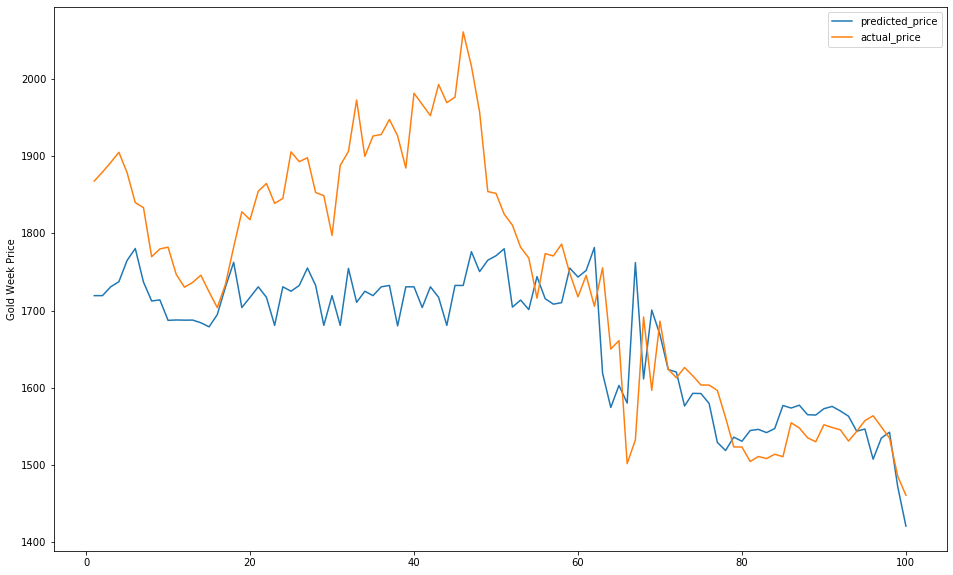

RMSE: 15686.954308799994


In [28]:
rf = RandomForestRegressor(n_estimators=final_n_estimators).fit(X_train, y_train)
predicted_price = rf.predict(X_test)
d = {'actual_price': y_test,'predicted_price': predicted_price}
df = pd.DataFrame(data=d)
df['actual_var'] = df.actual_price.shift(-1) - df.actual_price
df['actual_var_sign'] = np.sign(df.actual_var)
df['predicted_var'] = df.predicted_price.shift(1) - df.predicted_price
df['predicted_var_sign'] = df.predicted_var/abs(df.predicted_var)
df['correct_prediction'] = np.equal(df.actual_var_sign, df.predicted_var_sign)
predicted_price = pd.DataFrame(
    predicted_price, index=y_test.index, columns=['price'])
predicted_price.plot(figsize=(16, 10))
y_test.plot()
plt.legend(['predicted_price', 'actual_price'])
plt.ylabel("Gold Week Price")
plt.show()

rmse = mean_squared_error(y_test, predicted_price)
print("RMSE:", rmse)

In [29]:
df.head(30)
print("Número de linhas: {}".format(df.shape[0]))

Número de linhas: 100


In [30]:
r2_score = rf.score(X_test, y_test)*100
float("{0:.2f}".format(r2_score))

36.89

In [31]:
res = df.query('correct_prediction == True')
acertos = res.shape[0]
print("Acertos: {}".format(acertos))

Acertos: 46


## Linear SVM Regressor

In [32]:
epsilon_list = [0.1, 0.3]
C_list = 2**(np.random.uniform(-5, 15, 10))
final_r2 = np.NINF
for C_value in C_list:
    epsilon_value = random.choice(epsilon_list)
    lsvmr = LinearSVR(epsilon = epsilon_value, C = C_value, max_iter = 10000).fit(X_train, y_train)
    predicted_price = lsvmr.predict(X_test)
    r2_score = lsvmr.score(X_test, y_test)
    if r2_score > final_r2:
        final_r2 = r2_score
        final_epsilon = epsilon_value
        final_C = C_value
        final_coef0 = lsvmr.coef_[0]
        final_coef1 = lsvmr.coef_[1]
        final_coef2 = lsvmr.coef_[2]
        final_coef3 = lsvmr.coef_[3]
        final_intercept = lsvmr.intercept_
print("Resultado da busca por hiperparâmetros:")
print("Melhor R2 = {}".format(final_r2))
print("Valor do epsilon = {}".format(final_epsilon))
print("Valor do C = {}".format(final_C))
print("Linear SVM Regressor model")
print("Gold Week Price (y) = %.2f * Delta (x1) \
+ %.2f * 3 Days Moving Average (x2) \
+ %.2f * 5 Days Moving Average (x3) \
+ %.2f * 7 Days Moving Average (x4) \
+ %.2f (constant)" % (final_coef0, final_coef1, final_coef2, final_coef3, final_intercept))

Resultado da busca por hiperparâmetros:
Melhor R2 = 0.90781860384425
Valor do epsilon = 0.1
Valor do C = 301.65351163146676
Linear SVM Regressor model
Gold Week Price (y) = 0.60 * Delta (x1) + 1.42 * 3 Days Moving Average (x2) + -0.72 * 5 Days Moving Average (x3) + 0.31 * 7 Days Moving Average (x4) + 0.88 (constant)


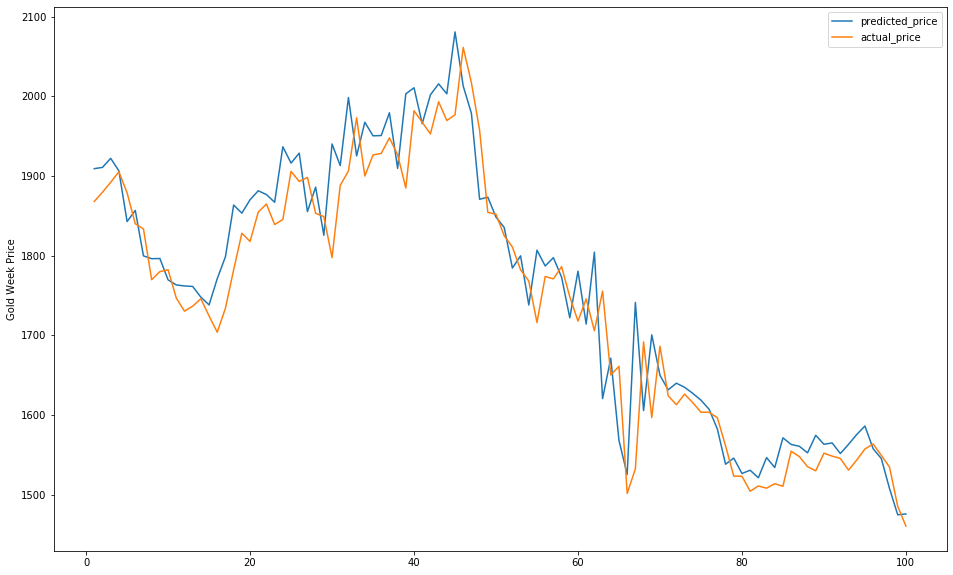

RMSE: 2568.7929690011542


In [33]:
lsvmr = LinearSVR(epsilon = final_epsilon, C = final_C, max_iter = 10000).fit(X_train, y_train)
predicted_price = lsvmr.predict(X_test)
d = {'actual_price': y_test,'predicted_price': predicted_price}
df = pd.DataFrame(data=d)
df['actual_var'] = df.actual_price.shift(-1) - df.actual_price
df['actual_var_sign'] = np.sign(df.actual_var)
df['predicted_var'] = df.predicted_price.shift(1) - df.predicted_price
df['predicted_var_sign'] = df.predicted_var/abs(df.predicted_var)
df['correct_prediction'] = np.equal(df.actual_var_sign, df.predicted_var_sign)
predicted_price = pd.DataFrame(
    predicted_price, index=y_test.index, columns=['price'])
predicted_price.plot(figsize=(16, 10))
y_test.plot()
plt.legend(['predicted_price', 'actual_price'])
plt.ylabel("Gold Week Price")
plt.show()

rmse = mean_squared_error(y_test, predicted_price)
print("RMSE:", rmse)

In [34]:
df.head(30)
print("Número de linhas: {}".format(df.shape[0]))

Número de linhas: 100


In [35]:
r2_score = lsvmr.score(X_test, y_test)*100
float("{0:.2f}".format(r2_score))

89.67

In [36]:
res = df.query('correct_prediction == True')
acertos = res.shape[0]
print("Acertos: {}".format(acertos))

Acertos: 48


## RBF SVM Regressor

In [37]:
epsilon_list = [0.1, 0.3]
C_list = 2**(np.random.uniform(-5, 15, 10))
gamma_list = 2**(np.random.uniform(-9, 3, 10))
final_r2 = np.NINF
for C_value in C_list:
    epsilon_value = random.choice(epsilon_list)
    gamma_value = random.choice(gamma_list)
    svr = SVR(gamma = gamma_value, epsilon = epsilon_value, C = C_value, kernel='rbf').fit(X_train, y_train)
    predicted_price = svr.predict(X_test)
    r2_score = svr.score(X_test, y_test)    
    if r2_score > final_r2:
        final_r2 = r2_score
        final_epsilon = epsilon_value
        final_C = C_value
        final_gamma = gamma_value
        final_coef0 = lsvmr.coef_[0]
        final_coef1 = lsvmr.coef_[1]
        final_coef2 = lsvmr.coef_[2]
        final_coef3 = lsvmr.coef_[3]
        final_intercept = lsvmr.intercept_
print("Resultado da busca por hiperparâmetros:")
print("Melhor R2 = {}".format(final_r2))
print("Valor do epsilon = {}".format(final_epsilon))
print("Valor do C = {}".format(final_C))
print("Valor do gamma = {}".format(final_gamma))
print("RBF SVM Regressor model")
print("Gold Week Price (y) = %.2f * Delta (x1) \
+ %.2f * 3 Days Moving Average (x2) \
+ %.2f * 5 Days Moving Average (x3) \
+ %.2f * 7 Days Moving Average (x4) \
+ %.2f (constant)" % (final_coef0, final_coef1, final_coef2, final_coef3, final_intercept))

Resultado da busca por hiperparâmetros:
Melhor R2 = -15.619527224711057
Valor do epsilon = 0.1
Valor do C = 0.031286272836007205
Valor do gamma = 3.0833559734373575
RBF SVM Regressor model
Gold Week Price (y) = 0.59 * Delta (x1) + 1.44 * 3 Days Moving Average (x2) + -0.71 * 5 Days Moving Average (x3) + 0.28 * 7 Days Moving Average (x4) + 0.86 (constant)


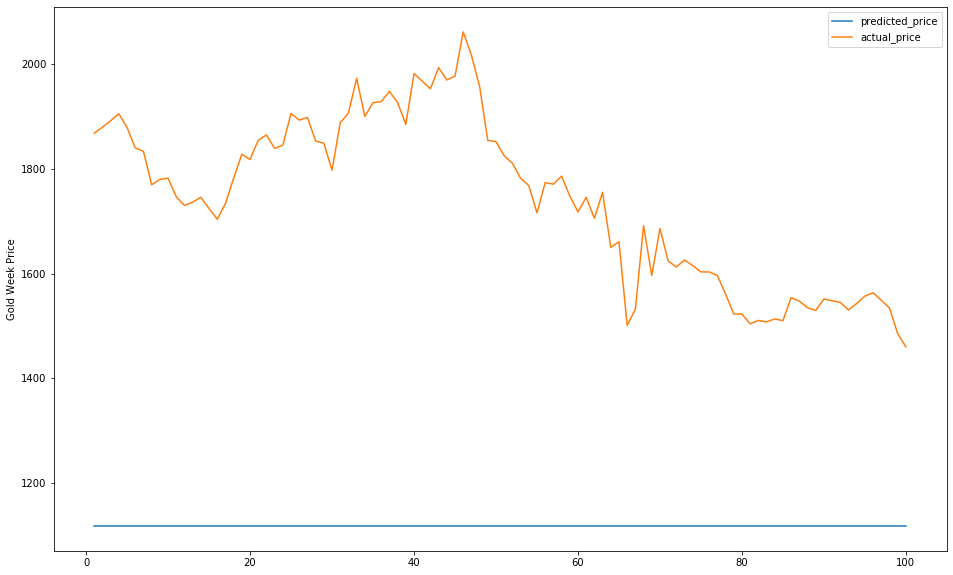

RMSE: 413131.76340000005


In [38]:
svr = SVR(gamma = final_gamma, epsilon = final_epsilon, C = final_C, kernel='rbf').fit(X_train, y_train)
predicted_price = svr.predict(X_test)
d = {'actual_price': y_test,'predicted_price': predicted_price}
df = pd.DataFrame(data=d)
df['actual_var'] = df.actual_price.shift(-1) - df.actual_price
df['actual_var_sign'] = np.sign(df.actual_var)
df['predicted_var'] = df.predicted_price.shift(1) - df.predicted_price
df['predicted_var_sign'] = df.predicted_var/abs(df.predicted_var)
df['correct_prediction'] = np.equal(df.actual_var_sign, df.predicted_var_sign)
predicted_price = pd.DataFrame(
    predicted_price, index=y_test.index, columns=['price'])
predicted_price.plot(figsize=(16, 10))
y_test.plot()
plt.legend(['predicted_price', 'actual_price'])
plt.ylabel("Gold Week Price")
plt.show()

rmse = mean_squared_error(y_test, predicted_price)
print("RMSE:", rmse)

In [39]:
df.head(30)
print("Número de linhas: {}".format(df.shape[0]))

Número de linhas: 100


In [40]:
r2_score = svr.score(X_test, y_test)*100
float("{0:.2f}".format(r2_score))

-1561.95

In [41]:
res = df.query('correct_prediction == True')
acertos = res.shape[0]
print("Acertos: {}".format(acertos))

Acertos: 0


# Sem delta

In [42]:
X_test = gold.filter(['m3','m5','m7'],axis=1).tail(100)
print('Conjunto X de teste')
print("Número de linhas: {}\nNúmero de colunas: {}".format(X_test.shape[0], X_test.shape[1]))
X_test.head()

Conjunto X de teste
Número de linhas: 100
Número de colunas: 3


,m3,m5,m7
100,1451.000000,1446.50,1427.985714
99,1458.933333,1452.04,1439.200000
98,1470.400000,1459.74,1454.028571
97,1493.400000,1479.32,1468.571429
96,1523.000000,1498.98,1483.200000


In [43]:
X_train = gold.filter(['m3','m5','m7'],axis=1).head(-100)
print('Conjunto X de treino')
print("Número de linhas: {}\nNúmero de colunas: {}".format(X_train.shape[0], X_train.shape[1]))
X_train.head()

Conjunto X de treino
Número de linhas: 987
Número de colunas: 3


,m3,m5,m7
1087,274.833333,276.46,278.085714
1086,275.333333,275.26,276.785714
1085,275.966667,275.12,276.200000
1084,274.800000,275.26,275.228571
1083,274.200000,274.70,274.457143


## Linear Regressor

In [44]:
cross_val = cross_validate(
    LinearRegression(),
    X_train,
    y_train,
    scoring=('neg_root_mean_squared_error')
)
rmse_medio =  np.sqrt(np.mean(np.absolute(cross_val['test_score'])))
print("RMSE = {}".format(rmse_medio))

RMSE = 5.288362312578554


In [45]:
linear = LinearRegression().fit(X_train, y_train)
print("Linear Regression model")
print("Gold Week Price (y) = %.2f * 3 Days Moving Average (x1) \
+ %.2f * 5 Days Moving Average (x2) \
+ %.2f * 7 Days Moving Average (x3) \
+ %.2f (constant)" % (linear.coef_[0], linear.coef_[1], linear.coef_[2], linear.intercept_))

Linear Regression model
Gold Week Price (y) = 1.75 * 3 Days Moving Average (x1) + -1.14 * 5 Days Moving Average (x2) + 0.39 * 7 Days Moving Average (x3) + 4.58 (constant)


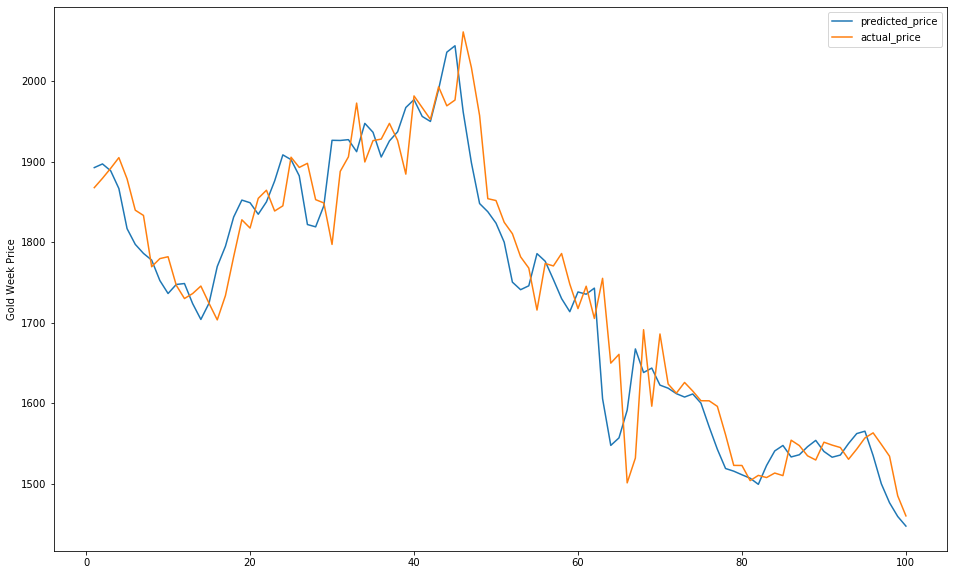

In [46]:
predicted_price = linear.predict(X_test)
d = {'actual_price': y_test,'predicted_price': predicted_price}
df = pd.DataFrame(data=d)
df['actual_var'] = df.actual_price.shift(-1) - df.actual_price
df['actual_var_sign'] = np.sign(df.actual_var)
df['predicted_var'] = df.predicted_price.shift(1) - df.predicted_price
df['predicted_var_sign'] = df.predicted_var/abs(df.predicted_var)
df['correct_prediction'] = np.equal(df.actual_var_sign, df.predicted_var_sign)
predicted_price = pd.DataFrame(
    predicted_price, index=y_test.index, columns=['price'])
predicted_price.plot(figsize=(16, 10))
y_test.plot()
plt.legend(['predicted_price', 'actual_price'])
plt.ylabel("Gold Week Price")
plt.show()

In [47]:
df.head(30)
print("Número de linhas: {}".format(df.shape[0]))

Número de linhas: 100


In [48]:
r2_score = linear.score(X_test, y_test)*100
float("{0:.2f}".format(r2_score))

90.55

In [49]:
res = df.query('correct_prediction == True')
acertos = res.shape[0]
print("Acertos: {}".format(acertos))

Acertos: 43


In [50]:
alpha_list = 10**(np.random.uniform(-3, 3, 50))
final_r2 = np.NINF
for alpha_value in alpha_list:
    ridge = Ridge(alpha=alpha_value).fit(X_train, y_train)
    predicted_price = ridge.predict(X_test)
    r2_score = ridge.score(X_test, y_test)
    if r2_score > final_r2:
        final_r2 = r2_score
        final_alpha = alpha_value
        final_coef0 = ridge.coef_[0]
        final_coef1 = ridge.coef_[1]
        final_coef2 = ridge.coef_[2]
        final_coef3 = ridge.coef_[3]
        final_intercept = ridge.intercept_
print("Resultado da busca por hiperparâmetros:")
print("Melhor R2 = {}".format(final_r2))
print("Melhor alpha = {}".format(final_alpha))
print("Linear Regression model with Ridge (l2) regularization")
print("Gold Week Price (y) = %.2f * Delta (x1) \
+ %.2f * 3 Days Moving Average (x2) \
+ %.2f * 5 Days Moving Average (x3) \
+ %.2f * 7 Days Moving Average (x4) \
+ %.2f (constant)" % (final_coef0, final_coef1, final_coef2, final_coef3, final_intercept))

IndexError: index 3 is out of bounds for axis 0 with size 3

In [ ]:
ridge = Ridge(alpha=final_alpha).fit(X_train, y_train)
predicted_price = ridge.predict(X_test)
d = {'actual_price': y_test,'predicted_price': predicted_price}
df = pd.DataFrame(data=d)
df['actual_var'] = df.actual_price.shift(1) - df.actual_price
df['actual_var_sign'] = np.sign(df.actual_var)
df['predicted_var'] = df.predicted_price.shift(1) - df.predicted_price
df['predicted_var_sign'] = df.predicted_var/abs(df.predicted_var)
df['correct_prediction'] = np.equal(df.actual_var_sign, df.predicted_var_sign)
predicted_price = pd.DataFrame(
    predicted_price, index=y_test.index, columns=['price'])
predicted_price.plot(figsize=(16, 10))
y_test.plot()
plt.legend(['predicted_price', 'actual_price'])
plt.ylabel("Gold Week Price")
plt.show()
rmse = mean_squared_error(y_test, predicted_price)
print("RMSE:", rmse)